In [1]:
# --- 1) Enhanced Imports & Config ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
import base64
from io import BytesIO
import torch
from transformers import AutoImageProcessor, AutoModel
import pickle
import os
import warnings

# Suppress scikit-learn deprecation warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='umap')

# config
VIDEO_PATH = 'videos/short.mp4'
MODEL_PATH = 'yolov8n.pt'
CONF_THRESH = 0.3
EMBEDDINGS_CACHE = 'embeddings_cache.pkl'

# Load SigLip model for embeddings
print("Loading SigLip model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
siglip_model = AutoModel.from_pretrained("google/siglip-base-patch16-224").to(device)
siglip_processor = AutoImageProcessor.from_pretrained("google/siglip-base-patch16-224")
siglip_model.eval()
print(f"SigLip loaded on {device}")

Loading SigLip model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


SigLip loaded on cpu


In [2]:
# --- 2) Enhanced Helper Functions with SigLip ---
def get_siglip_embedding(image):
    """Create embedding using SigLip vision encoder"""
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    
    # Process image
    inputs = siglip_processor(images=pil_img, return_tensors="pt").to(device)
    # print(f"inputs: {inputs}")
    
    # Get embeddings
    with torch.no_grad():
        outputs = siglip_model.get_image_features(**inputs)
        # print(f"outputs: {outputs}")
        embedding = outputs.cpu().numpy().flatten()
    
    return embedding

def crop_player(frame, x1, y1, x2, y2):
    """Simple crop with bounds checking"""
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = max(0, int(x1)), max(0, int(y1)), min(w, int(x2)), min(h, int(y2))
    
    if x2 <= x1 or y2 <= y1:
        return None
    
    return frame[y1:y2, x1:x2]

def image_to_base64(image):
    """Convert OpenCV image to base64 for plotly hover"""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    buffer = BytesIO()
    pil_img.save(buffer, format="PNG")
    img_str = base64.b64encode(buffer.getvalue()).decode()
    return f"data:image/png;base64,{img_str}"

In [3]:
# --- 3) Enhanced Detection with TV Logo Filtering ---

# Check if embeddings cache exists
if os.path.exists(EMBEDDINGS_CACHE):
    print(f"Loading embeddings from cache: {EMBEDDINGS_CACHE}")
    with open(EMBEDDINGS_CACHE, 'rb') as f:
        cache_data = pickle.load(f)
        all_crops = cache_data['crops']
        all_embeddings = cache_data['embeddings']
        ball_crops = cache_data['ball_crops']
        frame_count = cache_data['frame_count']
        video_width = cache_data['video_width']
        video_height = cache_data['video_height']
        detection_metadata = cache_data.get('detection_metadata', [])
    
    # Check if metadata exists, if not, regenerate cache
    if not detection_metadata:
        print("⚠️ Warning: Old cache format detected (missing detection_metadata)")
        print("Deleting cache and reprocessing video...")
        os.remove(EMBEDDINGS_CACHE)
        # Force reprocessing by setting flag
        import sys
        print("Please rerun this cell to regenerate the cache with metadata.")
        sys.exit("Cache regeneration needed")
    
    print(f"Loaded {len(all_crops)} person detections, {len(ball_crops)} ball detections from cache")
    print(f"Loaded {len(detection_metadata)} detection metadata entries")
else:
    print("No cache found, processing video...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print(f"Error: Could not open video {VIDEO_PATH}")
        exit()

    model = YOLO(MODEL_PATH)

    # Storage for different object types
    all_crops = []
    all_embeddings = []
    ball_crops = []
    detection_metadata = []  # Store frame_idx and bbox for each detection
    frame_count = 0

    # Get video dimensions for position-based filtering
    video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Video dimensions: {video_width}x{video_height}")

    print("Processing video with SigLip embeddings and TV logo filtering...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Detect objects
        results = model(frame, conf=CONF_THRESH, verbose=False)
        
        # Process detections
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cls = int(box.cls)
                    conf = float(box.conf)
                    
                    # Process persons (players, goalkeepers, referees)
                    if cls == 0:  # person class
                        # Better filtering to avoid TV logos and small detections
                        width = x2 - x1
                        height = y2 - y1
                        area = width * height
                        aspect_ratio = height / width if width > 0 else 0
                        
                        # Position-based filtering for TV logos (top-right corner)
                        center_x = (x1 + x2) / 2
                        center_y = (y1 + y2) / 2
                        
                        # Filter out detections in top-right corner (TV logo area)
                        if (center_x > video_width * 0.75 and center_y < video_height * 0.25):
                            continue
                        
                        # Filter out small detections, very wide/tall boxes, and edge detections
                        if (area < 2000 or area > 50000 or  # Size filter
                            aspect_ratio < 1.2 or aspect_ratio > 4.0 or  # Aspect ratio filter
                            width < 30 or height < 50 or  # Minimum dimensions
                            x1 < 10 or y1 < 10 or  # Too close to edges
                            x2 > video_width - 10 or y2 > video_height - 10):
                            continue
                        
                        # Additional filter for very small objects that might be logos
                        if area < 3000 and center_y < video_height * 0.3:  # Small objects in upper part
                            continue
                        
                        # Crop player
                        crop = crop_player(frame, x1, y1, x2, y2)
                        if crop is not None:
                            # Get SigLip embedding
                            embedding = get_siglip_embedding(crop)
                            all_crops.append(crop)
                            all_embeddings.append(embedding)
                            # Store metadata: frame index and bounding box
                            detection_metadata.append({
                                'frame_idx': frame_count,
                                'bbox': (x1, y1, x2, y2),
                                'detection_idx': len(all_crops) - 1
                            })
                    
                    # Process sports ball
                    elif cls == 32:  # sports ball class
                        width = x2 - x1
                        height = y2 - y1
                        area = width * height
                        
                        # Filter ball detections
                        if area > 50 and area < 2000 and conf > 0.5:
                            crop = crop_player(frame, x1, y1, x2, y2)
                            if crop is not None:
                                ball_crops.append(crop)
        
        if frame_count % 50 == 0:
            print(f"Processed {frame_count+1} frames, found {len(all_crops)} people, {len(ball_crops)} balls")
        
        frame_count += 1

    cap.release()
    print(f"Done! Found {len(all_crops)} person detections, {len(ball_crops)} ball detections")
    print(f"Each person has a {len(all_embeddings[0]) if all_embeddings else 0}-dimensional SigLip embedding")
    
    # Save embeddings to cache
    print(f"Saving embeddings to cache: {EMBEDDINGS_CACHE}")
    cache_data = {
        'crops': all_crops,
        'embeddings': all_embeddings,
        'ball_crops': ball_crops,
        'frame_count': frame_count,
        'video_width': video_width,
        'video_height': video_height,
        'detection_metadata': detection_metadata
    }
    with open(EMBEDDINGS_CACHE, 'wb') as f:
        pickle.dump(cache_data, f)
    print("Cache saved successfully!")

Loading embeddings from cache: embeddings_cache.pkl
Loaded 3593 person detections, 41 ball detections from cache
Loaded 3593 detection metadata entries


Original embedding dimension: 768
Applying UMAP dimensionality reduction to 2D...
UMAP reduced 768D → 2D

Using 3 clusters (Team 1, Team 2, Referee)...
K=3: cluster sizes = [np.int64(1860), np.int64(1566), np.int64(167)]

Cluster analysis:
Cluster 0: 1860 people (51.8%)
Cluster 1: 167 people (4.6%)
Cluster 2: 1566 people (43.6%)

 Team Identification:
Cluster 0: TEAM 1 (1860 players, 51.8%)
Cluster 2: TEAM 2 (1566 players, 43.6%)
Cluster 1: REFEREE (167 people, 4.6%)


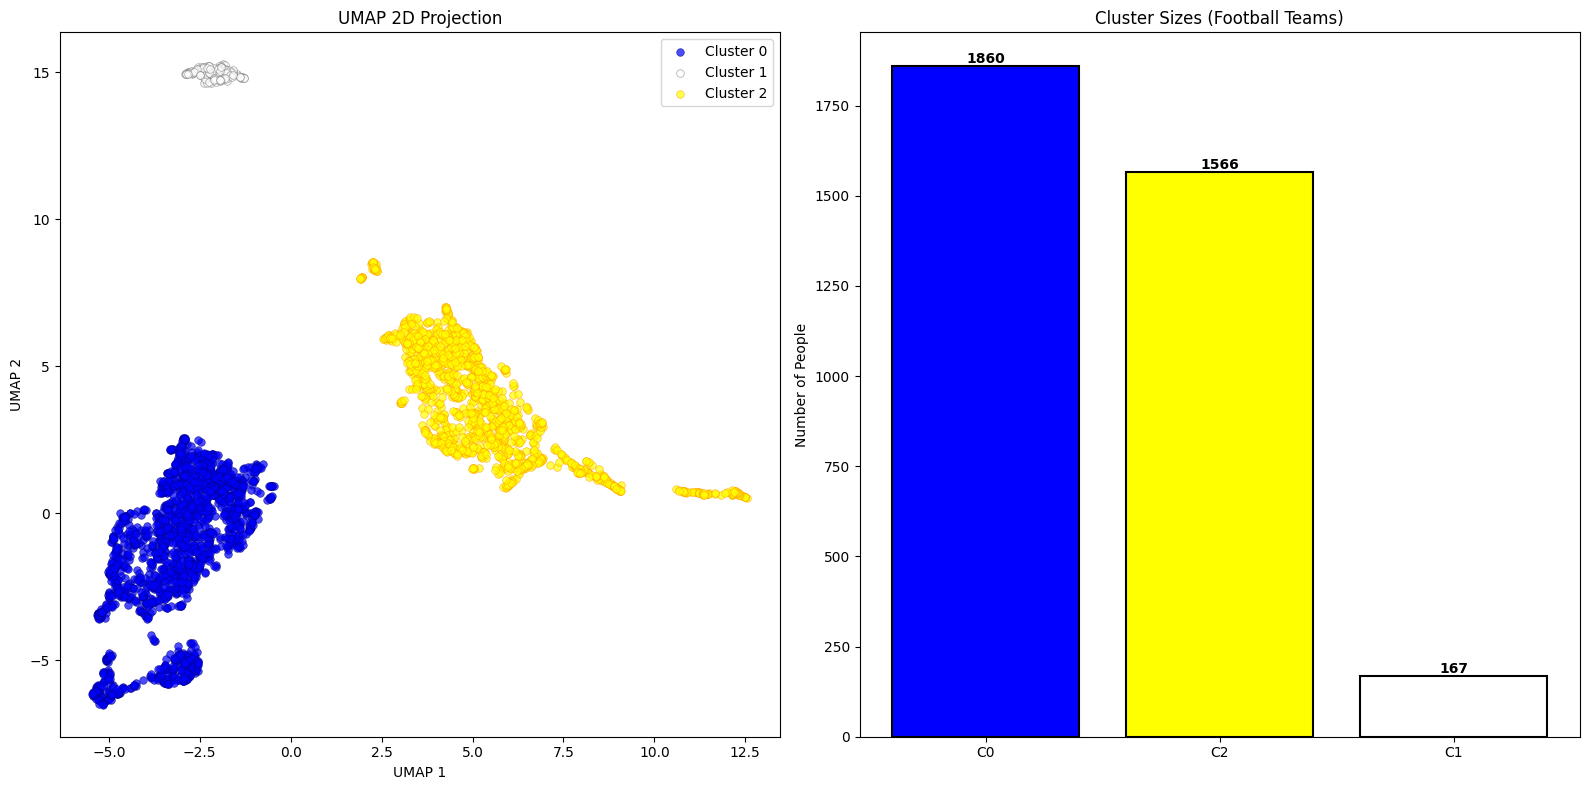

In [4]:
# --- 4) UMAP + Clustering on SigLip Embeddings (Optimized for 3 Clusters) ---
if len(all_embeddings) < 10:
    print("Not enough people detected for clustering")
else:
    # Convert embeddings to numpy array
    embeddings_array = np.array(all_embeddings)
    print(f"Original embedding dimension: {embeddings_array.shape[1]}")
    
    # Standardize embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_array)
    
    # Apply UMAP to reduce to 2D for visualization and better clustering
    # Remove random_state to avoid n_jobs warning, or set n_jobs=-1 for parallelism
    print("Applying UMAP dimensionality reduction to 2D...")
    umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, n_jobs=1)
    embeddings_2d = umap_reducer.fit_transform(embeddings_scaled)
    
    print(f"UMAP reduced {embeddings_array.shape[1]}D → 2D")
    
    # Fixed: Always use 3 clusters (Team 1, Team 2, Referee)
    print("\nUsing 3 clusters (Team 1, Team 2, Referee)...")
    
    best_k = 3
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
    team_labels = kmeans.fit_predict(embeddings_2d)
    
    # Count cluster sizes
    unique, counts = np.unique(team_labels, return_counts=True)
    sorted_counts = sorted(counts, reverse=True)
    
    print(f"K={best_k}: cluster sizes = {sorted_counts}")
    
    # Analyze clusters and identify teams
    print(f"\nCluster analysis:")
    cluster_info = []
    for i in range(best_k):
        cluster_mask = team_labels == i
        cluster_size = sum(cluster_mask)
        cluster_center_2d = embeddings_2d[cluster_mask].mean(axis=0)
        
        cluster_info.append({
            'id': i,
            'size': cluster_size,
            'center_2d': cluster_center_2d,
            'percentage': cluster_size / len(all_embeddings) * 100
        })
        
        print(f"Cluster {i}: {cluster_size} people ({cluster_size/len(all_embeddings)*100:.1f}%)")
    
    # Sort clusters by size to identify teams
    cluster_info.sort(key=lambda x: x['size'], reverse=True)
    
    print("\n Team Identification:")
    for i, info in enumerate(cluster_info):
        if i == 0:
            print(f"Cluster {info['id']}: TEAM 1 ({info['size']} players, {info['percentage']:.1f}%)")
        elif i == 1:
            print(f"Cluster {info['id']}: TEAM 2 ({info['size']} players, {info['percentage']:.1f}%)")
        elif i == 2:
            if info['percentage'] < 20:
                print(f"Cluster {info['id']}: REFEREE ({info['size']} people, {info['percentage']:.1f}%)")
            else:
                print(f"Cluster {info['id']}: TEAM 2 (continued) ({info['size']} players, {info['percentage']:.1f}%)")
    
    # Enhanced Visualization with UMAP
    fig = plt.figure(figsize=(16, 8))
    
    # Plot 1: UMAP 2D projection (left)
    ax1 = plt.subplot(1, 2, 1)
    colors = ['blue', 'white', 'yellow', 'red', 'purple', 'brown', 'pink']
    edge_colors = ['darkblue', 'gray', 'orange', 'darkred', 'purple', 'brown', 'pink']
    
    for i in range(best_k):
        cluster_mask = team_labels == i
        cluster_points = embeddings_2d[cluster_mask]
        ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=colors[i % len(colors)], alpha=0.7, s=30,
                   edgecolors=edge_colors[i % len(edge_colors)], linewidth=0.5,
                   label=f'Cluster {i}')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.set_title('UMAP 2D Projection')
    ax1.legend()
    
    # Plot 2: Cluster sizes (right)
    ax2 = plt.subplot(1, 2, 2)
    cluster_sizes = [info['size'] for info in cluster_info]
    cluster_ids = [f"C{info['id']}" for info in cluster_info]
    bar_colors = [colors[info['id'] % len(colors)] for info in cluster_info]
    bars = plt.bar(cluster_ids, cluster_sizes, color=bar_colors, edgecolor='black', linewidth=1.5)
    plt.title('Cluster Sizes (Football Teams)')
    plt.ylabel('Number of People')
    for bar, size in zip(bars, cluster_sizes):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(size), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [5]:
# --- Interactive UMAP with hover preview in a side panel ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import cv2

# Build the same scatter as before, but as a FigureWidget
figw = go.FigureWidget()

color_map = {0: 'blue', 1: 'lightgray', 2: 'yellow'}
traces = []

for i in range(best_k):
    cluster_mask = (team_labels == i)
    cluster_points = embeddings_2d[cluster_mask]
    cluster_indices = np.where(cluster_mask)[0]

    # Keep only a small customdata: original crop index
    customdata = np.array(cluster_indices).reshape(-1, 1)

    traces.append(go.Scatter(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        mode='markers',
        name=f'Cluster {i}',
        marker=dict(size=8, color=color_map.get(i, 'gray'),
                    line=dict(width=1, color='black')),
        customdata=customdata,
        hovertemplate='Cluster: '+str(i)+'<br>UMAP1: %{x:.3f}<br>UMAP2: %{y:.3f}<extra></extra>'
    ))

for t in traces:
    figw.add_trace(t)

figw.update_layout(
    title='UMAP 2D Projection — hover a point to preview its crop',
    xaxis_title='UMAP 1',
    yaxis_title='UMAP 2',
    width=900,
    height=650,
    hovermode='closest',
    template='plotly_white'
)

# A preview pane on the right
preview = widgets.Output(layout={'border': '1px solid #444', 'width': '260px', 'height': '260px'})
caption  = widgets.HTML("<b>Hover preview</b><br><span style='color:#888'>(move the mouse over a point)</span>")

box = widgets.HBox([figw, widgets.VBox([caption, preview])])
display(box)

# Hover callbacks: show the crop in the preview pane
def make_hover_handler(trace):
    def _on_hover(trace, points, state):
        with preview:
            preview.clear_output(wait=True)
            if not points.point_inds:
                return
            # Recover the original index into all_crops from customdata
            local_idx = points.point_inds[0]
            global_idx = int(trace.customdata[local_idx][0])

            crop_bgr = all_crops[global_idx]
            crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
            crop_rgb = cv2.resize(crop_rgb, (224, 224), interpolation=cv2.INTER_AREA)
            display(Image.fromarray(crop_rgb))
    return _on_hover

def make_unhover_handler(trace):
    def _on_unhover(trace, points, state):
        # Optionally clear preview when leaving a point
        pass
    return _on_unhover

for tr in figw.data:
    tr.on_hover(make_hover_handler(tr))
    tr.on_unhover(make_unhover_handler(tr))


c:\Users\pavle\AppData\Local\Programs\Python\Python313\Lib\site-packages\kaleido\_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




    'data': [{'customdata': {'bdata': ('AwAEAAYACAAKAA0ADwARABQAFQAWAB' ... '3xD…

In [ ]:
# --- 6) Annotate Video with Clusters (Fast - Using Pre-computed Assignments) ---
print("Creating annotated video with cluster colors (using pre-computed data)...")

# Verify we have the required data
if not detection_metadata:
    print("❌ Error: No detection metadata found!")
    print("Please delete 'embeddings_cache.pkl' and rerun cell 3 to regenerate the cache.")
else:
    print(f"✓ Found {len(detection_metadata)} detections to annotate")

# Create a mapping from (frame_idx, bbox) to cluster assignment
print("Building frame-to-cluster mapping...")
frame_detections = {}
for i, metadata in enumerate(detection_metadata):
    frame_idx = metadata['frame_idx']
    if frame_idx not in frame_detections:
        frame_detections[frame_idx] = []
    
    # Add cluster assignment
    cluster = team_labels[i]
    frame_detections[frame_idx].append({
        'bbox': metadata['bbox'],
        'cluster': cluster
    })

print(f"Mapped {len(detection_metadata)} detections across {len(frame_detections)} frames")

# Load YOLO model if not already loaded
if 'model' not in globals():
    model = YOLO(MODEL_PATH)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print(f"Error: Could not open video {VIDEO_PATH}")
else:
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define output path
    output_path = 'videos/annotated_output.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Define colors for clusters (BGR format)
    cluster_colors = {
        0: (255, 0, 0),      # Blue gray for Team 1
        1: (200, 200, 200),  # Light Gray for Team 2
        2: (0, 255, 255)     # Yellow for Referee
    }
    
    # Fixed ellipse size for all players
    FIXED_ELLIPSE_WIDTH = 40
    FIXED_ELLIPSE_HEIGHT = 12
    
    # Ball color (consistent green)
    BALL_COLOR = (0, 255, 0)  # Bright green
    
    # Temporal smoothing: store recent detections
    player_history = {}
    ball_history = []
    max_history = 10
    iou_threshold = 0.2
    
    # Enhanced ball tracking parameters
    BALL_PERSISTENCE_FRAMES = 8
    BALL_MAX_SPEED = 150
    BALL_CONF_THRESHOLD = 0.15
    POSSESSION_DISTANCE_THRESHOLD = 120  # Distance to consider ball "with" a player
    
    def compute_iou(box1, box2):
        """Compute IoU between two boxes (x1, y1, x2, y2)"""
        x1_1, y1_1, x2_1, y2_1 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        
        xi1 = max(x1_1, x1_2)
        yi1 = max(y1_1, y1_2)
        xi2 = min(x2_1, x2_2)
        yi2 = min(y2_1, y2_2)
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        
        box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
        box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
        union_area = box1_area + box2_area - inter_area
        
        return inter_area / union_area if union_area > 0 else 0
    
    def compute_distance(box1, box2):
        """Compute center distance between two boxes"""
        c1_x = (box1[0] + box1[2]) / 2
        c1_y = (box1[1] + box1[3]) / 2
        c2_x = (box2[0] + box2[2]) / 2
        c2_y = (box2[1] + box2[3]) / 2
        return np.sqrt((c1_x - c2_x)**2 + (c1_y - c2_y)**2)
    
    def find_nearest_player(position, player_history, current_frame, max_time_diff=3):
        """Find the player nearest to a given position"""
        min_dist = float('inf')
        nearest_player_id = None
        nearest_player_pos = None
        
        for player_id, history in player_history.items():
            if not history:
                continue
            
            last_frame = history[-1]['frame']
            if abs(current_frame - last_frame) > max_time_diff:
                continue
            
            bbox = history[-1]['bbox']
            player_x = (bbox[0] + bbox[2]) / 2
            player_y = bbox[3]  # Feet position
            
            dist = np.sqrt((player_x - position[0])**2 + (player_y - position[1])**2)
            
            if dist < min_dist:
                min_dist = dist
                nearest_player_id = player_id
                nearest_player_pos = (player_x, player_y)
        
        if min_dist < POSSESSION_DISTANCE_THRESHOLD:
            return nearest_player_id, nearest_player_pos
        return None, None
    
    def predict_ball_position(ball_history, current_frame):
        """Predict ball position based on recent trajectory"""
        if len(ball_history) < 2:
            return None
        
        last = ball_history[-1]
        prev = ball_history[-2]
        
        if current_frame - last['frame'] > 5:
            return None
        
        dt = last['frame'] - prev['frame']
        if dt == 0:
            return last['center']
        
        vx = (last['center'][0] - prev['center'][0]) / dt
        vy = (last['center'][1] - prev['center'][1]) / dt
        
        time_ahead = current_frame - last['frame']
        pred_x = last['center'][0] + vx * time_ahead
        pred_y = last['center'][1] + vy * time_ahead
        
        return (pred_x, pred_y)
    
    def is_valid_ball_detection(center, ball_history, current_frame):
        """Check if detection is consistent with ball trajectory"""
        if not ball_history:
            return True
        
        predicted = predict_ball_position(ball_history, current_frame)
        if predicted is None:
            return True
        
        dist = np.sqrt((center[0] - predicted[0])**2 + (center[1] - predicted[1])**2)
        return dist < BALL_MAX_SPEED
    
    frame_idx = 0
    ball_possession_player = None
    
    # Progress tracking
    total_frames_to_process = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    progress_checkpoints = [int(total_frames_to_process * p / 100) for p in range(10, 100, 10)]
    import time
    processing_start = time.time()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Update player tracking with current frame detections
        current_players = []
        if frame_idx in frame_detections:
            for detection in frame_detections[frame_idx]:
                bbox = detection['bbox']
                cluster = detection['cluster']
                
                # Try to match with existing tracked players (using both IoU and distance)
                best_match_id = None
                best_match_score = 0
                
                for player_id, history in player_history.items():
                    if not history:
                        continue
                    
                    last_bbox = history[-1]['bbox']
                    last_frame = history[-1]['frame']
                    
                    # Only consider recent tracks
                    if frame_idx - last_frame > max_history:
                        continue
                    
                    # Compute IoU and distance
                    iou = compute_iou(bbox, last_bbox)
                    distance = compute_distance(bbox, last_bbox)
                    
                    # Combined score: prefer IoU, but use distance as fallback
                    # Distance threshold of ~100 pixels is reasonable for frame-to-frame movement
                    if iou > iou_threshold or distance < 100:
                        score = iou + (1.0 / (1.0 + distance / 50.0))  # Normalize distance
                        if score > best_match_score:
                            best_match_score = score
                            best_match_id = player_id
                
                if best_match_id is not None:
                    # Update existing player track
                    player_history[best_match_id].append({'bbox': bbox, 'cluster': cluster, 'frame': frame_idx})
                    if len(player_history[best_match_id]) > max_history:
                        player_history[best_match_id].pop(0)
                    current_players.append(best_match_id)
                else:
                    # New player track
                    new_id = len(player_history)
                    player_history[new_id] = [{'bbox': bbox, 'cluster': cluster, 'frame': frame_idx}]
                    current_players.append(new_id)
        
        # Draw all active players with smoothed positions
        active_positions = []
        
        for player_id, history in player_history.items():
            if not history:
                continue
            
            # Check if player was seen recently
            last_frame = history[-1]['frame']
            if frame_idx - last_frame > max_history:
                continue
            
            bbox = history[-1]['bbox']
            cluster = history[-1]['cluster']
            
            # Calculate smoothed position by averaging recent detections
            recent_positions = []
            for h in history[-5:]:  # Use last 5 frames for smoothing
                hx1, hy1, hx2, hy2 = h['bbox']
                recent_positions.append(((hx1 + hx2) / 2, hy2))
            
            # Average positions for smooth movement
            if recent_positions:
                center_x = sum(p[0] for p in recent_positions) / len(recent_positions)
                center_y = sum(p[1] for p in recent_positions) / len(recent_positions)
            else:
                x1, y1, x2, y2 = bbox
                center_x = (x1 + x2) / 2
                center_y = y2
            
            # Check if this position is too close to an already drawn ellipse
            is_duplicate = False
            for drawn_pos in active_positions:
                dist = np.sqrt((center_x - drawn_pos[0])**2 + (center_y - drawn_pos[1])**2)
                if dist < 30:
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                active_positions.append((center_x, center_y))
                
                # Draw ellipse around player's feet with FIXED size
                center = (int(center_x), int(center_y))
                axes = (FIXED_ELLIPSE_WIDTH, FIXED_ELLIPSE_HEIGHT)
                color = cluster_colors.get(cluster, (255, 255, 255))
                
                cv2.ellipse(frame, center, axes, 0, 0, 360, color, 3)
        
        # Enhanced ball detection with possession tracking
        results = model(frame, conf=BALL_CONF_THRESHOLD, verbose=False, classes=[32])
        
        ball_candidates = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = float(box.conf)
                    
                    width_box = x2 - x1
                    height_box = y2 - y1
                    area = width_box * height_box
                    
                    if 30 < area < 2500 and conf > BALL_CONF_THRESHOLD:
                        ball_center = ((x1 + x2) / 2, (y1 + y2) / 2)
                        
                        if is_valid_ball_detection(ball_center, ball_history, frame_idx):
                            ball_candidates.append({
                                'center': ball_center,
                                'conf': conf,
                                'area': area
                            })
        
        # Process ball detection and possession
        if ball_candidates:
            # Ball detected - update possession tracking
            best_ball = max(ball_candidates, key=lambda b: b['conf'] * (1.0 if 100 < b['area'] < 800 else 0.5))
            ball_center = best_ball['center']
            
            # Find nearest player to this detection
            nearest_player_id, _ = find_nearest_player(ball_center, player_history, frame_idx)
            
            # Update ball history with detection
            ball_history.append({
                'center': ball_center,
                'frame': frame_idx,
                'type': 'detected',
                'possession_player': nearest_player_id
            })
            
            # If ball was with a player and now detected with same/different player
            if ball_possession_player is not None and nearest_player_id is not None:
                # Ball still with same player or changed hands
                ball_possession_player = nearest_player_id
            elif nearest_player_id is not None:
                # Ball just picked up
                ball_possession_player = nearest_player_id
            else:
                # Ball is loose (not near any player)
                ball_possession_player = None
            
            if len(ball_history) > 20:
                ball_history.pop(0)
        else:
            # Ball not detected - check if a player has possession
            if ball_history:
                last_ball = ball_history[-1]
                frames_since_detection = frame_idx - last_ball['frame']
                
                # If ball was recently with a player, assume they still have it
                if frames_since_detection <= 15 and last_ball.get('possession_player') is not None:
                    possession_player_id = last_ball['possession_player']
                    
                    # Check if this player is still visible
                    if possession_player_id in player_history:
                        player_hist = player_history[possession_player_id]
                        if player_hist and frame_idx - player_hist[-1]['frame'] <= 3:
                            # Player still visible - assume ball is with them
                            bbox = player_hist[-1]['bbox']
                            estimated_ball_pos = ((bbox[0] + bbox[2]) / 2, bbox[3])
                            
                            ball_history.append({
                                'center': estimated_ball_pos,
                                'frame': frame_idx,
                                'type': 'possession',
                                'possession_player': possession_player_id
                            })
                            ball_possession_player = possession_player_id
                            
                            if len(ball_history) > 20:
                                ball_history.pop(0)
        
        # Draw ball with simplified single color and position smoothing
        if ball_history:
            last_ball = ball_history[-1]
            frames_since_update = frame_idx - last_ball['frame']
            
            if frames_since_update <= BALL_PERSISTENCE_FRAMES:
                # Calculate smoothed ball position from recent history
                recent_ball_positions = []
                for b in ball_history[-5:]:  # Use last 5 ball positions for smoothing
                    if frame_idx - b['frame'] <= BALL_PERSISTENCE_FRAMES:
                        recent_ball_positions.append(b['center'])
                
                # Average positions for smooth ball movement
                if len(recent_ball_positions) > 0:
                    center_x = sum(p[0] for p in recent_ball_positions) / len(recent_ball_positions)
                    center_y = sum(p[1] for p in recent_ball_positions) / len(recent_ball_positions)
                else:
                    # Fallback to prediction or last known
                    if frames_since_update == 0:
                        center_x, center_y = last_ball['center']
                    elif frames_since_update <= 3:
                        predicted = predict_ball_position(ball_history, frame_idx)
                        if predicted:
                            center_x, center_y = predicted
                        else:
                            center_x, center_y = last_ball['center']
                    else:
                        center_x, center_y = last_ball['center']
                
                # Draw triangle - single consistent color
                pt1 = (int(center_x), int(center_y - 25))
                pt2 = (int(center_x - 12), int(center_y - 8))
                pt3 = (int(center_x + 12), int(center_y - 8))
                
                triangle = np.array([pt1, pt2, pt3], np.int32)
                cv2.fillPoly(frame, [triangle], BALL_COLOR)
                cv2.polylines(frame, [triangle], True, (0, 0, 0), 2)
        
        # Write annotated frame
        out.write(frame)
        
        # Progress tracking every 10%
        if frame_idx in progress_checkpoints:
            elapsed = time.time() - processing_start
            progress_pct = (frame_idx / total_frames_to_process) * 100
            fps_current = frame_idx / elapsed if elapsed > 0 else 0
            eta_seconds = (total_frames_to_process - frame_idx) / fps_current if fps_current > 0 else 0
            
            print(f"  📊 {progress_pct:.0f}% complete ({frame_idx}/{total_frames_to_process})")
            print(f"     ⏱️  Elapsed: {int(elapsed//60)}:{int(elapsed%60):02d} | ETA: {int(eta_seconds//60)}:{int(eta_seconds%60):02d} | Speed: {fps_current:.1f} FPS")
        
        frame_idx += 1
    
    cap.release()
    out.release()
    
    total_processing_time = time.time() - processing_start
    print(f"\n✓ Done! Annotated video saved to: {output_path}")
    print(f"Total frames processed: {frame_idx}")
    print(f"Total processing time: {int(total_processing_time//60)}:{int(total_processing_time%60):02d}")
    print(f"Average speed: {frame_idx/total_processing_time:.1f} FPS")
    print(f"Total unique players tracked: {len(player_history)}")
    
    # Simplified statistics
    detected_frames = sum(1 for b in ball_history if b.get('type') == 'detected')
    possession_frames = sum(1 for b in ball_history if b.get('type') == 'possession')
    visible_frames = len([b for b in ball_history if b['frame'] >= frame_idx - frame_idx])  # Total ball history
    
    print(f"\nBall Tracking Statistics:")
    print(f"  Detected: {detected_frames} frames ({detected_frames/frame_idx*100:.1f}%)")
    print(f"  In possession: {possession_frames} frames ({possession_frames/frame_idx*100:.1f}%)")
    print(f"  Total visible: {len(ball_history)} frames ({len(ball_history)/frame_idx*100:.1f}%)")

Creating annotated video with cluster colors (using pre-computed data)...
✓ Found 3593 detections to annotate
Building frame-to-cluster mapping...
Mapped 3593 detections across 308 frames
Processed 1 frames...
Processed 51 frames...
Processed 101 frames...
Processed 151 frames...
Processed 201 frames...
Processed 251 frames...
Processed 301 frames...

✓ Done! Annotated video saved to: videos/annotated_output.mp4
Total frames processed: 308
Total unique players tracked: 28

Ball Tracking Statistics:
  Detected: 1 frames (0.3%)
  In possession: 19 frames (6.2%)
  Total visible: 20 frames (6.5%)
